# Distributional Reinforcement Learning

The main objective will be to replicate the results and insights from: 

- *[2] Dabney, W., Kurth-Nelson, Z., Uchida, N., Starkweather, C. K., Hassabis, D., Munos, R., & Botvinick, M. (2020). A distributional code for value in dopamine-based reinforcement learning. Nature, 577(7792), 671-675.*


## Is learning a Single Value?
In essence on TD-learning we reduced learning to one averaged value. However the reality of rewards can be better explained by a distribution of predicted values, as we can see in the picture, taken from [2].
# ![Jump Distribution](Jump_distribution.png)

So, how to learn "value distributions"?

The key difference in distributional RL lies in how ‘anticipated reward’ is defined. Distributional RL uses a multiplicity of predictions. These predictions vary the degree of optimism or pesimism about a reward.

Notably, distributional RL can increase performance in deep learning systems.

### Setup: Different Value Sensitivities in Neural Cells
 To implement distributional RL, we need neural cells that respond differently to positive and negative outcomes. As shown in the image from [2], cells exhibit varying sensitivities:
 
 - Some cells are more sensitive to rewards exceeding expectations (optimistic cells)
 - Some cells respond equally to all outcomes (neutral cells) 
 - Some cells are more sensitive to rewards below expectations (pessimistic cells)
 <img src="optimistic_pesimistic_cells.png" width="500"/>
 
 This represents a key difference from classical TD learning **(a)**. Instead of all cells learning the same value estimate, in distributional RL **(b)** each cell learns to track different aspects of the value distribution:
 
 <img src="Classical_TD_Distributional_TD.png" width="850"/>

### TD-distributional errors
 Let $f: \mathbb{R} \rightarrow \mathbb{R}$ be a response function.
 For each observed state $s$, let there be a set of value predictions $V_i(s)$, updated with learning rates $\alpha_i^+, \alpha_i^- \in \mathbb{R}^+$.
 Given states $s$, $s'$, reward $r$, and discount factor $\gamma$, we compute TD-errors:
 
 $\delta_i = r + \gamma V_j(s') - V_i(s)$
 
 where $V_j(s')$ is a sample from the distribution $V(s')$. The model then updates according to:
 
 $V_i(s) \leftarrow V_i(s) + \alpha_i^+ \cdot f(\delta_i) \quad \text{for } \delta_i > 0$
 
 $V_i(s) \leftarrow V_i(s) + \alpha_i^- \cdot f(\delta_i) \quad \text{for } \delta_i \leq 0$
 
 where $f(\delta) = \text{sgn}(\delta)$. Note that this method converges to the quantile $\tau_i = \frac{\alpha_i^+}{\alpha_i^+ + \alpha_i^-}$ of the distributions over discounted returns at s.






####  Value predictions vary among dopamine neurons:
* Suppose an agent has learned that a cue predicts a reward whose magnitude will be drawn from a probability distribution. In the standard RL theory, **the reversal point—the magnitude at which prediction errors transition from negative to positive—in standard RL is the expectation of the magnitude’s distribution**. By contrast, in distributional RL, **the reversal point differs across dopamine neurons according to their degree of optimism.**

* We found that dopamine neurons had substantially different reversal points, ranging from cells that reversed between the smallest two rewards to cells that reversed between the largest two rewards.

* From experiments, they found some cells appeared pessimistic and others appeared optimistic, there was also a population of cells with approximately neutral responses. 



## Comparing Standard TD Learning and Distributional TD Learning

We will compare the mathematical formulations of standard TD learning and distributional TD learning approaches.

### Standard TD Learning with Utility Function
To model reward processing, we introduce a utility function that helps characterize subjective reward values:

Let $U(r)$ be a utility function with parameters:

 - $f_{max}$: Maximum saturated utility value
 - $\sigma$: Parameter controlling the smoothness of the utility curve

The utility function is defined as:

 $ U(r) = \frac{f_{\text{max}} \cdot \text{sign}(r) \cdot |r|^{0.5}}{|r|^{0.5} + \sigma^{0.5}} $

### TD Error Calculation
 For each neuron $i$, the TD error $\delta$ is computed as:

 $ \delta = U(r) - V_i $

 The value estimate is then updated according to:

$ V_i \leftarrow V_i + \alpha_i \cdot \eta \cdot \delta $

 where:

 - $\alpha_i$ is the learning rate specific to neuron $i$
 - $\eta$ is the global learning rate parameter

 ### Neural Response Model: Reward prediction error

 The firing rate response $R_{i,j}$ of neuron $i$ to reward $j$ is modeled as:

$ R_{i,j} = \alpha_i \cdot (U(r_j) - V_i)$ 

To facilitate comparison across neurons, we normalize the responses:

$ R_{i,j}^{\text{norm}} = \frac{R_{i,j}}{\text{std}(R_{i,:})} $

 where $\text{std}(R_{i,:})$ is the standard deviation of responses for neuron $i$ across all rewards.



In [29]:
### Training a single value.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.interpolate


conditions = ['0.1uL','0.3uL','1.2uL','2.5uL','5uL','10uL','20uL']

### Utility function model assumptions:
fmax = 10.
sigma = 200
utility_func = lambda r: (fmax * np.sign(r) * np.abs(r)**(.5)) / (np.abs(r)**(.5) + sigma**(.5))

#utility_func = lambda r: r
response_func = lambda r: r

reward_cmap = cm.get_cmap('plasma', len(conditions)).colors

def plot_zero_crossings(zero_crossings, responses, smooth=10.):
  fig = plt.figure(figsize=(6, 6))

  ind = list(np.argsort(zero_crossings))
  ind = np.array(ind)
  juice_response = responses[ind]
  xk = np.arange(len(ind))
  xs = np.linspace(0., len(ind)-1., 100)

  for cell in range(len(juice_response)):
    plt.plot([juice_response[cell].min(), juice_response[cell].max()],
             np.ones(2)*cell, linewidth=1, linestyle=':', color='k', zorder=1)

  for reward_ind in range(juice_response.shape[1]):
    plt.scatter(juice_response[:, reward_ind], np.arange(len(juice_response)),
                c=reward_cmap[reward_ind], linewidth=1, edgecolor='w', zorder=4,
                s=50, label=conditions[reward_ind])
    
    # Down weight endpoints for the interpolating spline
    weights = np.ones(len(ind))
    weights[-1] = 0.5
    weights[0] = 0.5

    cs = scipy.interpolate.UnivariateSpline(
        xk, juice_response[:, reward_ind], w=weights)

    cs.set_smoothing_factor(smooth)
    plt.plot(cs(xs), xs, c=reward_cmap[reward_ind], zorder=3,
             linewidth=2, alpha=1.)

  plt.axvline(linestyle='-', color='k', zorder=2, linewidth=2.)
  _ = plt.ylim([-1, len(juice_response)])

  ax = plt.gca()
  ax.xaxis.tick_bottom()

  plt.xlabel('$\\Delta$ Firing Rate (variance normalized)', fontsize=18)
  plt.ylabel('Cells', fontsize=18)




C:\Users\juanc\AppData\Local\Temp\ipykernel_26048\2200706900.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reward_cmap = cm.get_cmap('plasma', len(conditions)).colors


C:\Users\juanc\AppData\Local\Temp\ipykernel_26048\2200706900.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(juice_response[:, reward_ind], np.arange(len(juice_response)),


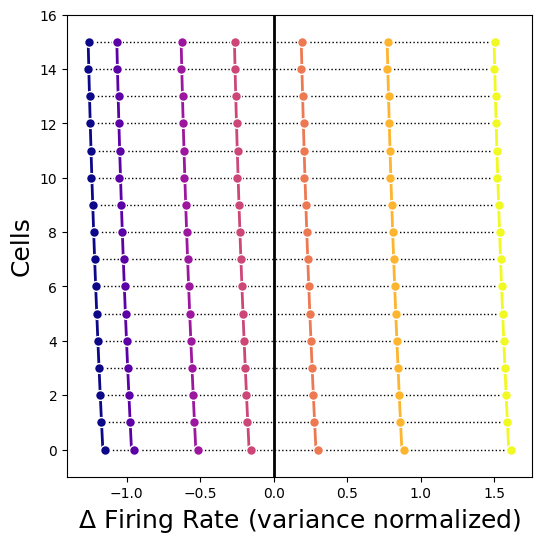

In [37]:
num_cells = 151
num_steps = 25000
trials = 10
base_lrate = 0.02

juice_probs = np.array(
    [0.06612594, 0.09090909, 0.14847358, 0.15489467,
     0.31159175, 0.1509519 , 0.07705306])
juice_amounts = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])

# Simulate classic TD
values = np.zeros((trials, num_cells))
alpha = np.random.random((trials, num_cells))

for trial in range(trials):
  for step in range(num_steps):
    reward = np.random.choice(juice_amounts, p=juice_probs)
    delta = utility_func(reward) - values[trial]
    values[trial] += alpha[trial] * response_func(delta) * base_lrate

ind = np.argsort(values)
values = np.array([v[i] for v, i in zip(values, ind)])
alpha = np.array([a[i] for a, i in zip(alpha, ind)])


responses = response_func(alpha[:, :, None] * (utility_func(juice_amounts)[None, None] - values[:, :, None]))
ind = np.argsort(values.mean(0))

responses = responses.mean(0)
responses = responses[ind]
responses /= responses.std(1, ddof=1, keepdims=True)

plot_zero_crossings(values.mean(0)[::10], responses[::10])

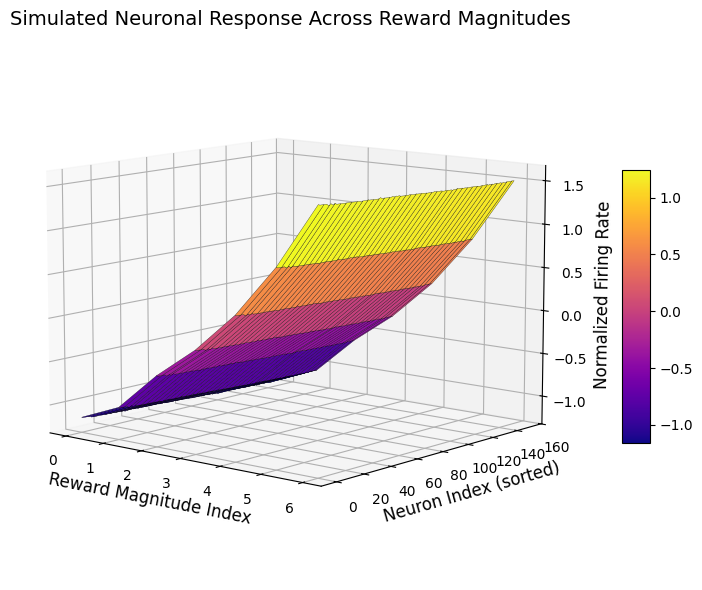

In [40]:
from mpl_toolkits.mplot3d import Axes3D  # sí, es necesario
import matplotlib.pyplot as plt

def plot_firing_rate_3d_over_time(responses, juice_amounts, skip=1):
    """
    Plot 3D surface of neuron responses over
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    neuron_indices = np.arange(0, responses.shape[0], skip)
    reward_indices = np.arange(len(juice_amounts))

    X, Y = np.meshgrid(reward_indices, neuron_indices)
    Z = responses[neuron_indices][:, reward_indices]

    surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, edgecolor='k', linewidth=0.2)

    ax.set_xlabel('Reward Magnitude Index', fontsize=12)
    ax.set_ylabel('Neuron Index (sorted)', fontsize=12)
    ax.set_zlabel('Normalized Firing Rate', fontsize=12)
    ax.set_title('Simulated Neuronal Response Across Reward Magnitudes', fontsize=14)
    ax.view_init(elev=10, azim=-50)

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

plot_firing_rate_3d_over_time(responses, juice_amounts)



## Temporal Difference Learning - Distributional

To model subjective reward learning across a population of neurons, we define a non-linear utility function that transforms objective rewards into subjective value:

### Utility Function

$$
U(r) = \frac{f_{max} \cdot \text{sign}(r) \cdot |r|^{0.5}}{|r|^{0.5} + \sigma^{0.5}}
$$

where:
- $f_{max}$ is the maximum subjective value (saturation point)
- $\sigma$ controls the curvature and smoothness of the saturation

## TD Error Computation (Per Neuron)

For each neuron $i$, the prediction error is computed as:

$$
\delta_i = U(r) - Z_i
$$

where:
- $Z_i$ is the current estimated quantile or value for neuron $i$

### Valence Function

We define the direction (valence) of the prediction error:

$$
\text{valence}_i = 
\begin{cases}
1, & \delta_i \leq 0 \quad \text{(negative prediction error)} \\
0, & \delta_i > 0 \quad \text{(positive prediction error)}
\end{cases}
$$

### Update Rule (Asymmetric Learning)

Each neuron's quantile estimate is updated using different learning rates for positive and negative errors:

$$
Z_i \leftarrow Z_i + \eta \cdot 
\left( 
\text{valence}_i \cdot \alpha^{-}_i + (1 - \text{valence}_i) \cdot \alpha^{+}_i
\right) \cdot \delta_i
$$

where:
- $\alpha^{+}_i$: learning rate for positive prediction errors
- $\alpha^{-}_i$: learning rate for negative prediction errors
- $\eta$: global learning rate (scalar)

### Neural Response Model

The firing rate response $R_{i,j}$ of neuron $i$ to reward $r_j$ is modeled as:

$$
R_{i,j} = 
\left( 
\alpha^{-}_i \cdot \mathbb{1}[\delta_{i,j} \leq 0] 
+ 
\alpha^{+}_i \cdot \mathbb{1}[\delta_{i,j} > 0]
\right) \cdot \delta_{i,j}
$$

with:

$$
\delta_{i,j} = U(r_j) - Z_i
$$

### Normalized Response (Across Rewards)

To allow for comparison across neurons, we normalize the response:

$$
R^{\text{norm}}_{i,j} = \frac{R_{i,j}}{\text{std}(R_{i,:})}
$$



C:\Users\juanc\AppData\Local\Temp\ipykernel_26048\2200706900.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(juice_response[:, reward_ind], np.arange(len(juice_response)),


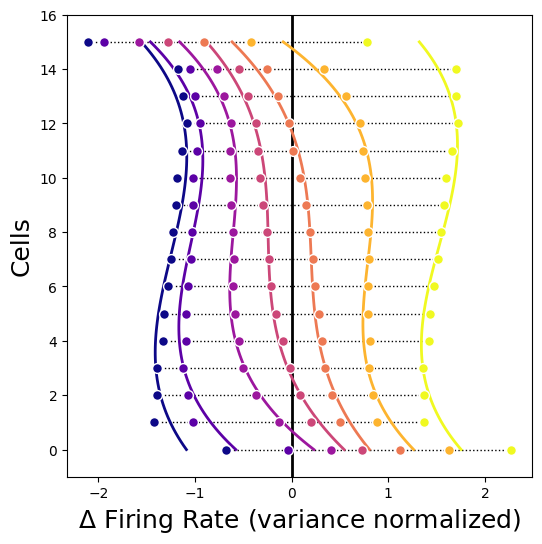

In [45]:
# Simulate distributional TD
distribution = np.zeros((trials, num_cells))

alpha_pos = np.random.random(size=(trials, num_cells))
alpha_neg = np.random.random(size=(trials, num_cells))
tau = alpha_pos / (alpha_pos + alpha_neg)

for trial in range(trials):
  for step in range(num_steps):
    reward = (np.random.choice(juice_amounts, p=juice_probs))
    delta = utility_func(reward) - distribution[trial]

    valence = np.array(delta <= 0., dtype=np.float32)
    distribution[trial] += (valence * alpha_neg[trial] + (1. - valence) * alpha_pos[trial]) * response_func(delta) * base_lrate

  ind = np.argsort(tau[trial])
  tau[trial] = tau[trial][ind]
  alpha_pos[trial] = alpha_pos[trial][ind]
  alpha_neg[trial] = alpha_neg[trial][ind]
  distribution[trial] = distribution[trial][ind]

delta = (utility_func(juice_amounts)[None, None] - distribution[:,:,None])
valence = np.array(delta <= 0., dtype=np.float32)
lrfloor = lambda x: 0.2 + x
responses = response_func(delta) * (valence * lrfloor(alpha_neg)[:, :, None] + (1. - valence) * lrfloor(alpha_pos)[:, :, None])
responses = responses.mean(0)
ind = np.argsort(distribution.mean(0))

responses = responses[ind]
responses /= (responses.std(1, ddof=1, keepdims=True))
plot_zero_crossings(distribution.mean(0)[::10], (responses[::10]))

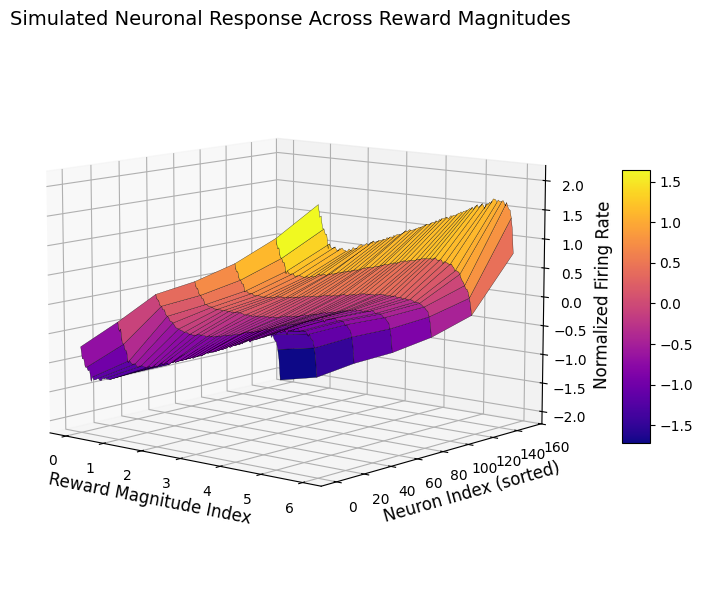

In [44]:
plot_firing_rate_3d_over_time(responses, juice_amounts)

### Conclusions.
 
 - In the classic model (TD):
 All neurons end up responding more or less the same way. The small differences seen are noise, not real signals.
 
 - In the distributional model (Distributional TD):
 Each neuron learns something different:
 
     - Some are optimistic (respond strongly even to small rewards).
 
     - Others are pessimistic (only respond to large rewards).
 
     - Others are neutral, as if they didn't care about anything.
 
 - In real dopamine data from Ventral Tegmental Area:
 We see exactly this diversity. Some neurons change their response with small rewards, others only with large ones.

 <img src="Neural_Data_Dist.png" width="450"/>

